$${\rm SNR} = \frac{({\rm source~flux})t_{\rm exp}}{\sqrt{(({\rm source~flux}) + ({\rm sky~flux}) + n_{\rm pix}{\rm DC})t_{\rm exp} + n_{\rm pix}{\rm RN}^2}} \approx \frac{({\rm source~flux})t_{\rm exp}}{\sqrt{(({\rm source~flux}) + ({\rm sky~flux}))t_{\rm exp} + n_{\rm pix}{\rm RN}^2}}$$


For the nominal exposure (short exposure time and dark conditions), we can't ignore the RN term

$${\rm SNR}_{\rm nom} \approx \frac{({\rm source~flux})t_{\rm nom}}{\sqrt{({\rm sky~flux})_{\rm nom} t_{\rm nom} + n_{\rm pix}{\rm RN}^2}}$$

But for BGS exposure where $t_{\rm exp}$ s longer and sky is brighter we can ignore the RN term

$${\rm SNR}_{\rm BGS} \approx \frac{({\rm source~flux})t_{\rm BGS}}{\sqrt{({\rm sky~flux})_{\rm BGS} t_{\rm BGS} + n_{\rm pix}{\rm RN}^2}}$$

To keep ${\rm SNR}$ constant, we'll have to scale the exposure time as 

$$ \frac{({\rm source~flux})t_{\rm BGS}}{\sqrt{({\rm sky~flux})_{\rm BGS} t_{\rm BGS} + n_{\rm pix}{\rm RN}^2}} = \frac{({\rm source~flux})t_{\rm nom}}{\sqrt{({\rm sky~flux})_{\rm nom} t_{\rm nom} + n_{\rm pix}{\rm RN}^2}}$$


solving for $t_{\rm BGS}$ we get: 

$$t_{\rm BGS} = t_{\rm nom} \frac{(\rm sky~flux) t_{\rm nom} + \sqrt{t_{\rm nom}^2 (\rm sky~flux)_{\rm BGS}^2 + 4{\rm RN}^2 ((\rm sky~flux)_{\rm nom}t_{\rm nom} + {\rm RN}^2)}}{2((\rm sky~flux)_{\rm nom} t_{\rm nom} + {\rm RN}^2)}$$



In [1]:
import os 
import h5py
import numpy as np 
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import astropy.units as u
# --- desihub --- 
import desisim.simexp
import specsim.instrument
from specsim.simulator import Simulator 

from desispec.io import read_frame
from desitarget.cmx import cmx_targetmask
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

In [4]:
instrument = specsim.instrument.initialize(config, True)

In [5]:
plate_scale = config.load_table(config.instrument.plate_scale, ['radius', 'radial_scale', 'azimuthal_scale'], interpolate=False)
radial_fiber_size = (0.5 * instrument.fiber_diameter / instrument.radial_scale(plate_scale['radius']))
azimuthal_fiber_size = (0.5 * instrument.fiber_diameter / instrument.azimuthal_scale(plate_scale['radius']))

desi_fiber_area = np.mean(np.pi*radial_fiber_size * azimuthal_fiber_size)
print('mean fiber area %f' % desi_fiber_area.value)

mean fiber area 1.862089


In [6]:
def bs_coadd(waves, sbrights): 
    ''' bullshit hack to combine wavelengths and surface brightnesses of the 3
    cameras...
    '''
    from scipy.interpolate import interp1d
    from desimodel.io import load_throughput
    # read nominal dark sky surface brightness
    wavemin = load_throughput('b').wavemin - 10.0
    wavemax = load_throughput('z').wavemax + 10.0
    outwave = np.arange(round(wavemin, 1), wavemax, 0.8) 
    
    sbrights_interp = [] 
    for wave, sbright in zip(waves, sbrights): 
        fintrp = interp1d(wave, sbright, fill_value=0., bounds_error=False) 
        sbrights_interp.append(fintrp(outwave))
    
    outsbright = np.amax(sbrights_interp, axis=0) 
    return outwave, outsbright 

In [7]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

In [8]:
nom_texp = 150 * u.s

nom_sky_sb = nominal_surface_brightness_dict['dark']
nom_sky_fibflux = nom_sky_sb * desi_fiber_area 
nom_sky_photon = nom_sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * nom_texp

nom_waves, nom_sky_electrons, nom_dark_electrons, read_noise_electrons = [], [], [], [] 
for camera in instrument.cameras: 
    nom_sky_electron = camera.downsample(camera.apply_resolution(nom_sky_photon * camera.throughput))
    nom_dark_electron = camera.downsample((camera.dark_current_per_bin * nom_texp).to(u.electron).value)
    read_noise_electron = camera.downsample(camera.read_noise_per_bin.to(u.electron).value)

    nom_waves.append(camera.output_wavelength.value)
    nom_sky_electrons.append(nom_sky_electron)
    nom_dark_electrons.append(nom_dark_electron)
    read_noise_electrons.append(read_noise_electron**2)

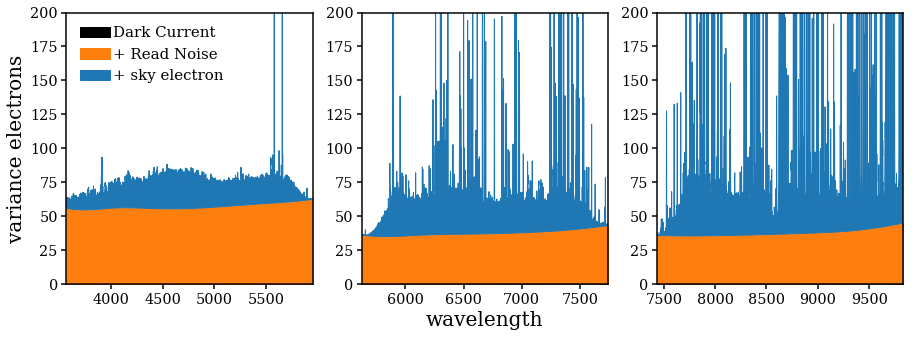

In [9]:
fig = plt.figure(figsize=(15,5))
for i in range(3): 
    sub = fig.add_subplot(1,3,i+1)
    sub.fill_between(nom_waves[i], np.zeros(len(nom_waves[i])), nom_dark_electrons[i], color='k', label='Dark Current')
    sub.fill_between(nom_waves[i], nom_dark_electrons[i], nom_dark_electrons[i] + read_noise_electrons[i], color='C1', label='+ Read Noise')
    sub.fill_between(nom_waves[i], nom_dark_electrons[i] + read_noise_electrons[i], nom_dark_electrons[i] + read_noise_electrons[i] + nom_sky_electrons[i], color='C0', label='+ sky electron')    
    if i == 1: sub.set_xlabel('wavelength', fontsize=20)
    sub.set_xlim(nom_waves[i].min(), nom_waves[i].max())
    if i == 0: 
        sub.set_ylabel('variance electrons', fontsize=20)
        sub.legend(loc='upper left', fontsize=15, handletextpad=0.2)
    sub.set_ylim(0., 200.)

In [10]:
# read sky surface brightnesses for CMX BGS exposures
fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'r')
skies = {}
for k in fskies.keys():
    skies[k] = fskies[k][...]
fskies.close()

(0.0, 10)

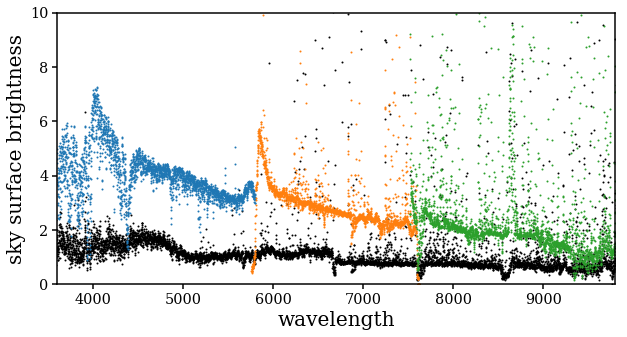

In [11]:
iexp = 0 

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(wave, nominal_surface_brightness_dict['dark'], c='k', s=1)
for band in ['b', 'r', 'z']: 
    sub.scatter(skies['wave_%s' % band], skies['sky_sb_%s' % band][iexp], s=1)
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylabel('sky surface brightness', fontsize=20)
sub.set_ylim(0., 10)

In [12]:
def get_fsky(_wave_sb, _sky_sb, wavelength=5000, plot=False):
    if wavelength < _wave_sb[0].max(): 
        i_cam = 0 
    elif _wave_sb[0].max() < wavelength & wavelength < _wave_sb[1].max(): 
        i_cam = 1
    elif _wave_sb[1].max() < wavelength:
        i_cam = 2
    else: 
        raise ValueError
        
    _wave, _sky = bs_coadd(_wave_sb, _sky_sb)

    sky_sb = _sky * nom_sky_sb.unit
    sky_fibflux = sky_sb * desi_fiber_area 
    sky_photon = sky_fibflux.to(u.erg/u.Angstrom/u.s/u.cm**2) * instrument.photons_per_bin * nom_texp

    if plot: 
        fig = plt.figure(figsize=(15,10))
        sub = fig.add_subplot(211)
        sub.scatter(wave, nominal_surface_brightness_dict['dark'], c='C0', s=1, label='nominal dark')
        sub.scatter(_wave, _sky, c='C1', s=1, label='CMX sky')
        sub.plot([wavelength, wavelength], [0., 20.], c='k', ls=':', lw=2)


        sub.legend(loc='upper right', fontsize=15, markerscale=5, handletextpad=0.15)
        sub.set_xlim(wave.value.min(), wave.value.max())
        sub.set_ylabel('sky surface brightness', fontsize=15)
        sub.set_ylim(0., 20.)

        sub = fig.add_subplot(212)

    for i, camera in enumerate(instrument.cameras): 
        sky_electron = camera.downsample(camera.apply_resolution(sky_photon * camera.throughput))
        
        if i == i_cam: 
            sky_bgs = np.interp(wavelength, camera.output_wavelength.value, sky_electron)
            rn = np.interp(wavelength, nom_waves[i_cam], read_noise_electrons[i_cam])
            sky_nom = np.interp(wavelength, nom_waves[i_cam], nom_sky_electrons[i_cam])

            fsky = (sky_bgs + np.sqrt(sky_bgs**2 + 4 * rn * (sky_nom + rn)))/(2. * (sky_nom + rn))
            
        if plot: 
            sub.plot(nom_waves[i], nom_sky_electrons[i]+read_noise_electrons[i], c='C0') 
            sub.plot(nom_waves[i], medfilt(nom_sky_electrons[i]+read_noise_electrons[i], 301), c='k', ls='--')

            sub.plot(camera.output_wavelength, sky_electron+read_noise_electrons[i], c='C1')
            sub.plot(camera.output_wavelength, medfilt(sky_electron + read_noise_electrons[i], 301), c='k', ls='--')
    
    if plot:     
        sub.plot([wavelength, wavelength], [0., 200.], c='k', ls=':', lw=2)
        sub.set_xlabel('wavelength', fontsize=20)
        sub.set_xlim(nom_waves[0].min(), nom_waves[2].max())
        sub.set_ylabel('variance electron', fontsize=20)
        sub.set_ylim(0., 200)
        plt.show()
    return fsky

--- 52932 ---


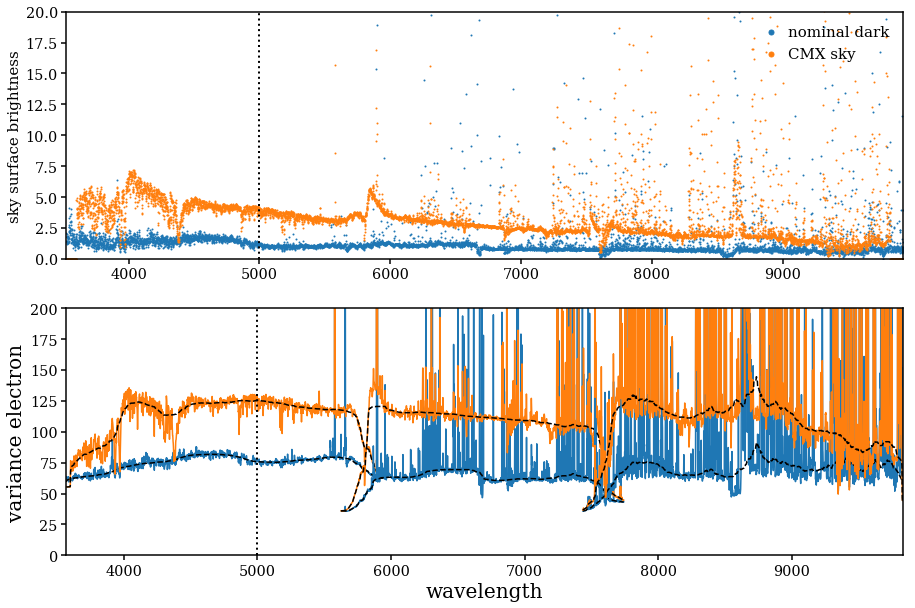

--- 52934 ---


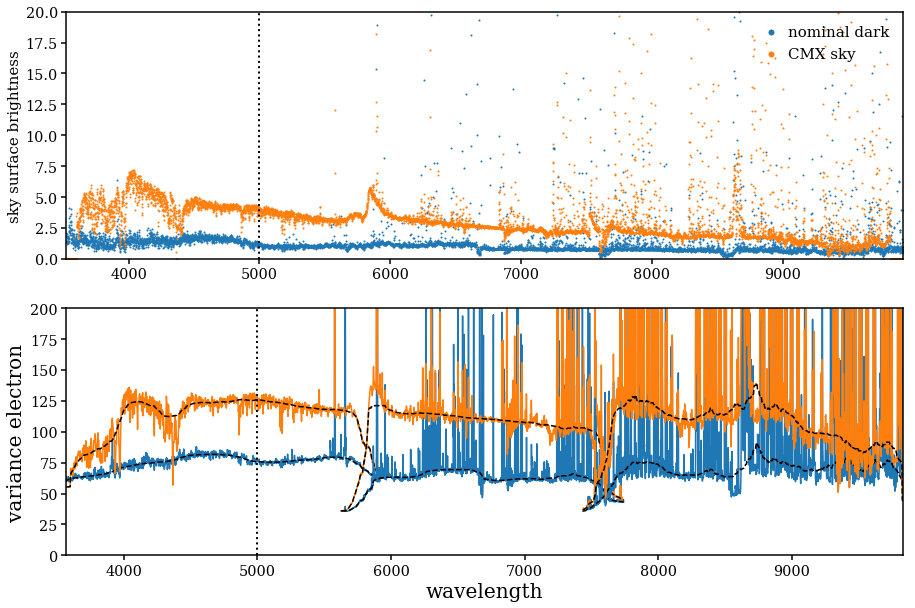

--- 52936 ---


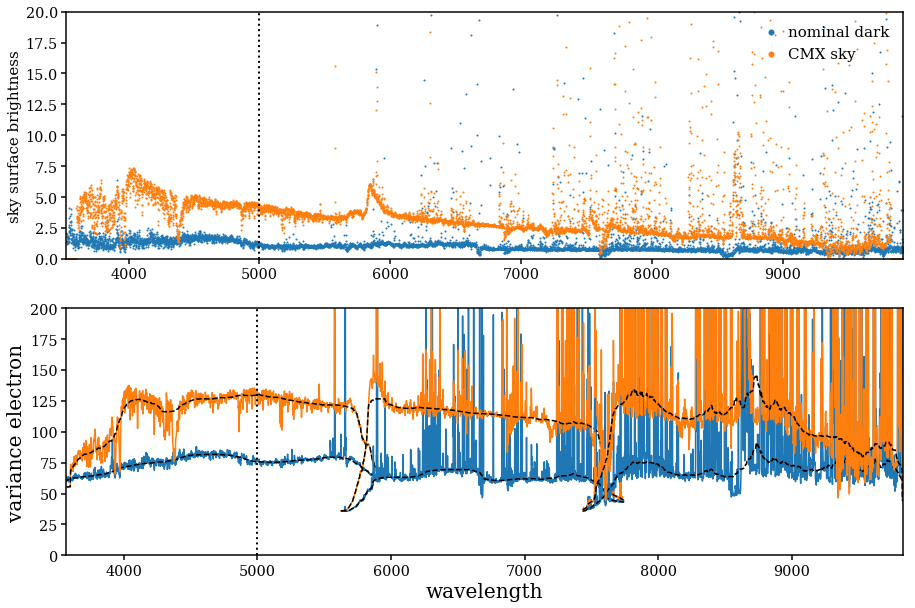

--- 52938 ---


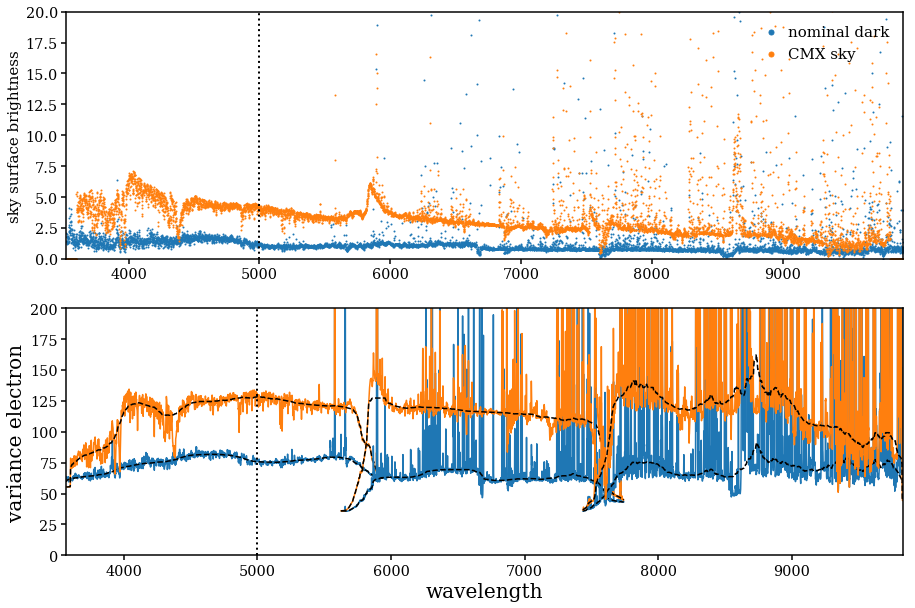

--- 52940 ---


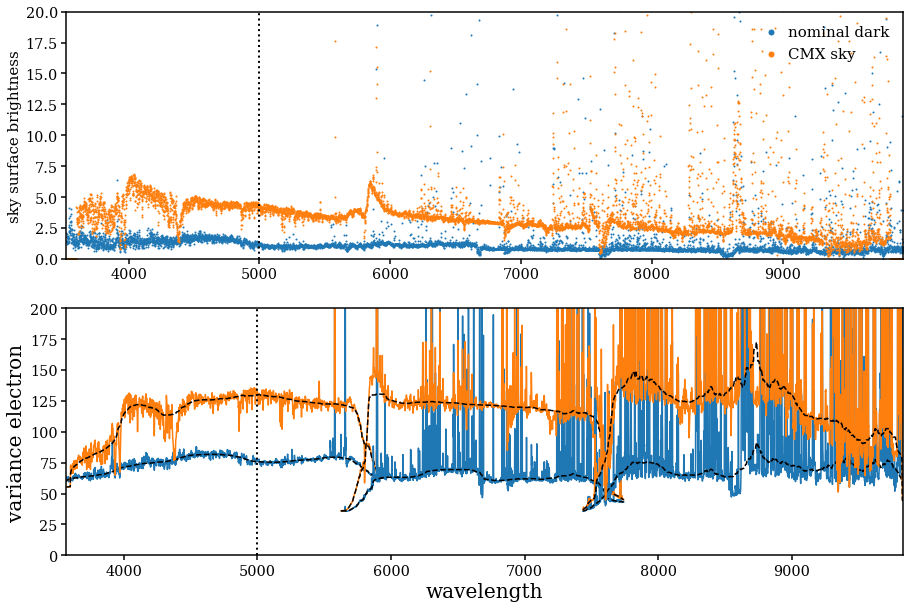

--- 52942 ---


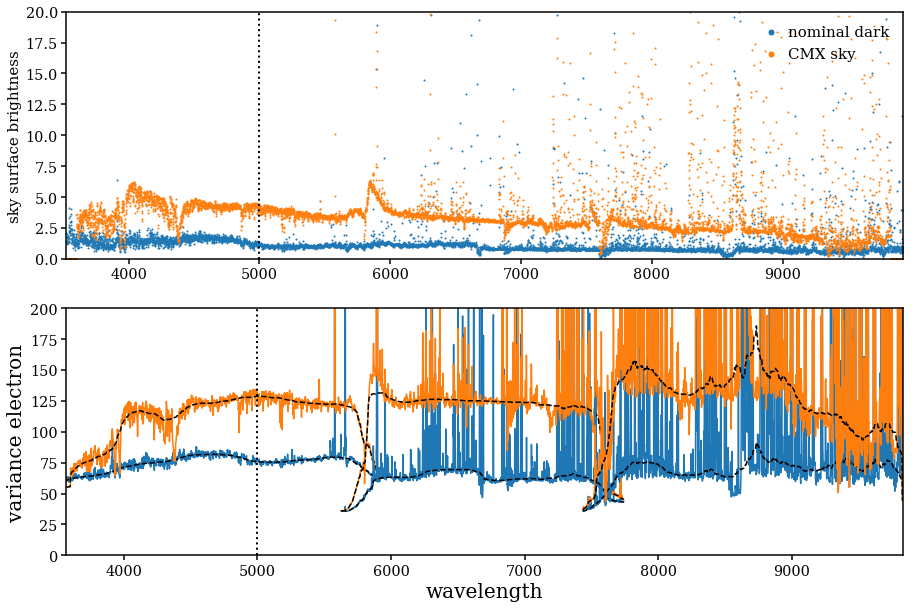

--- 52090 ---


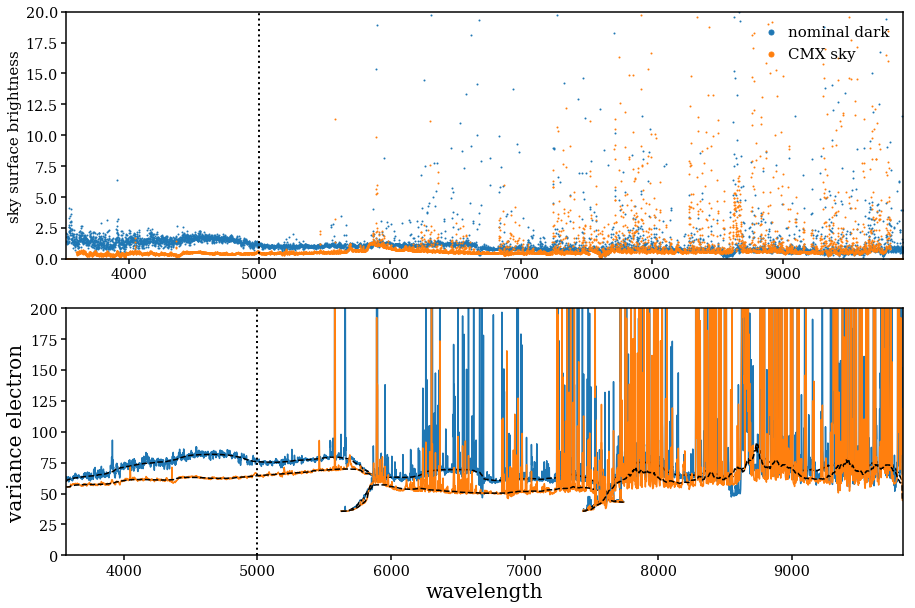

--- 52112 ---


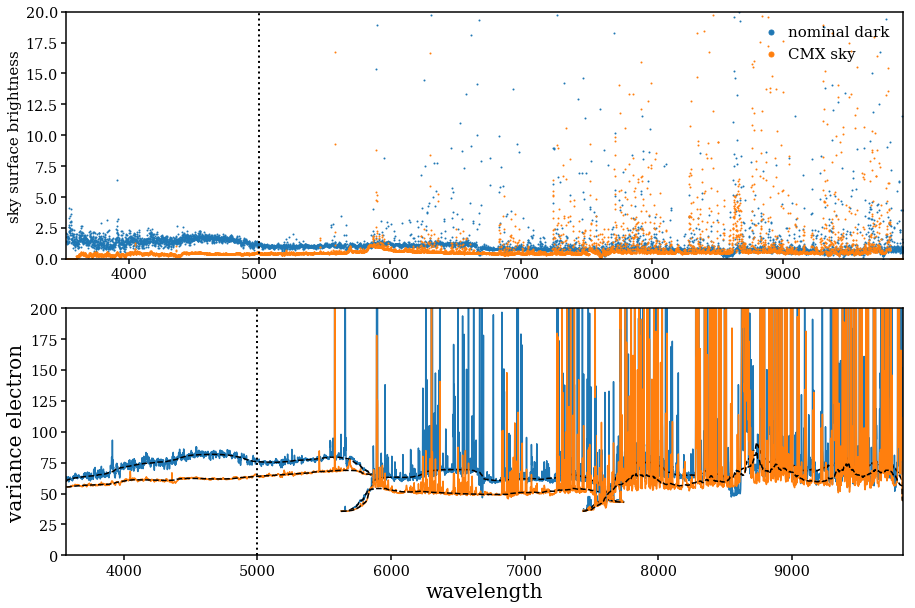

--- 52113 ---


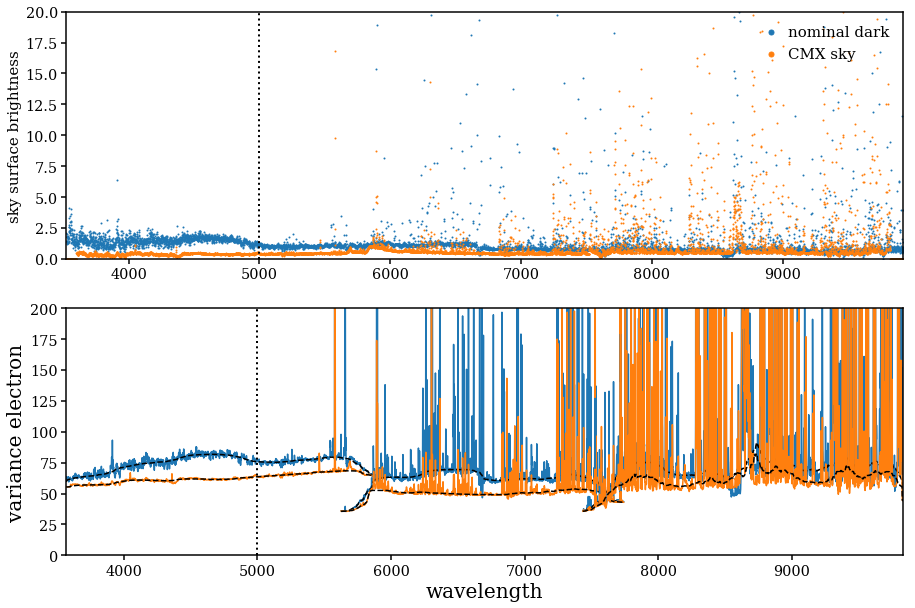

--- 52114 ---


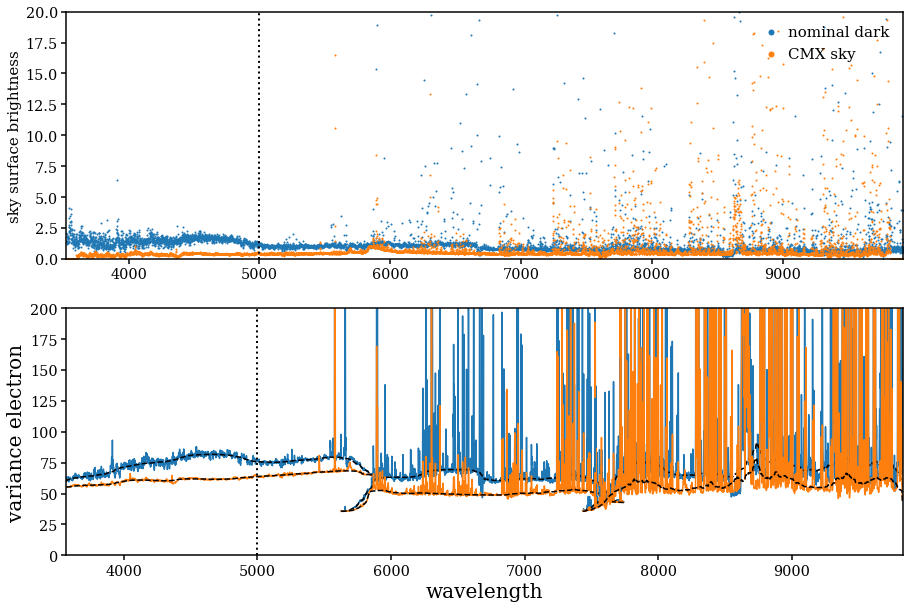

--- 52115 ---


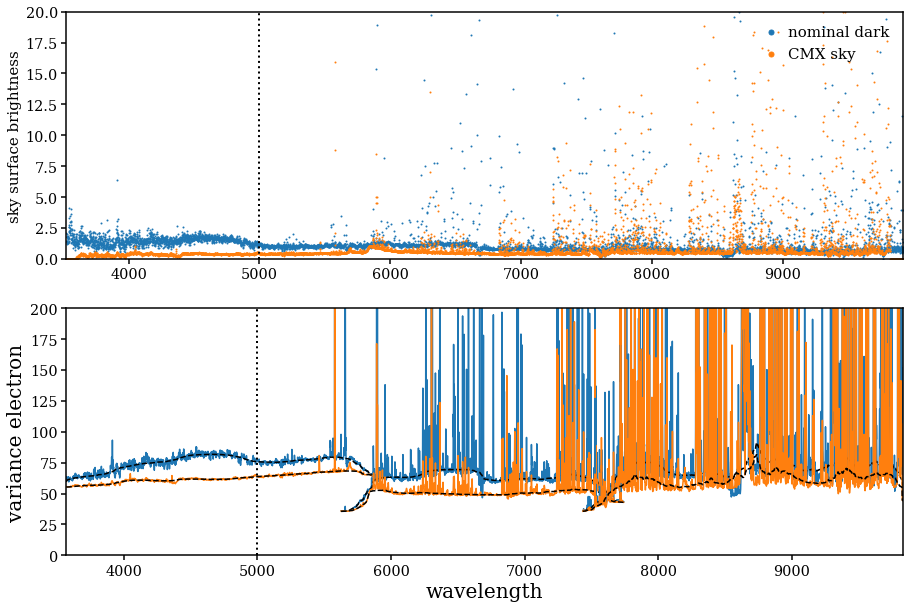

--- 52116 ---


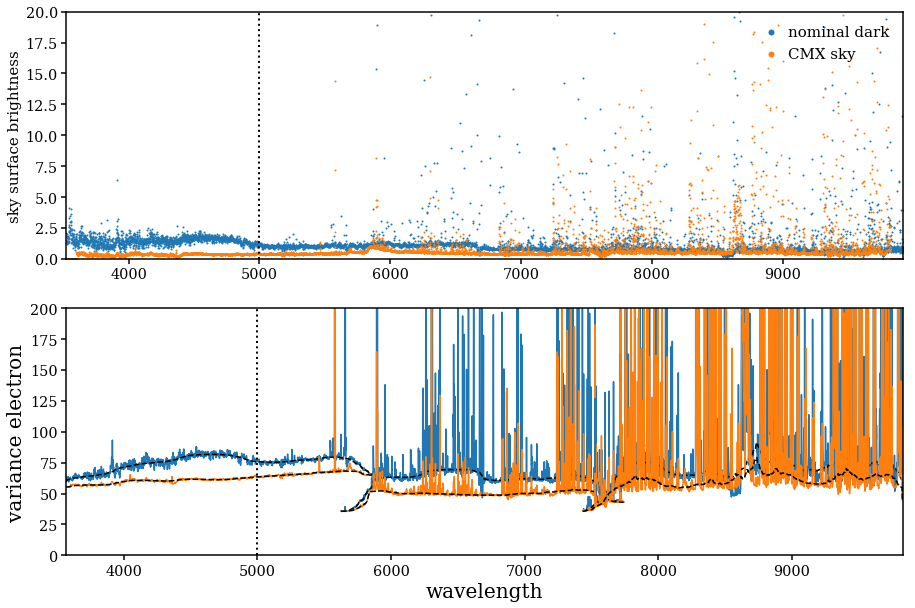

--- 53078 ---


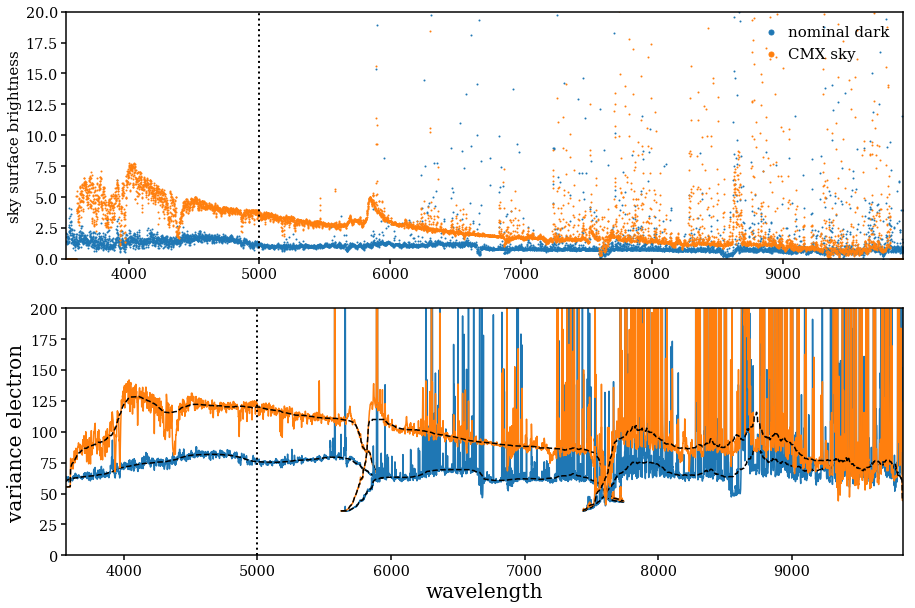

--- 53080 ---


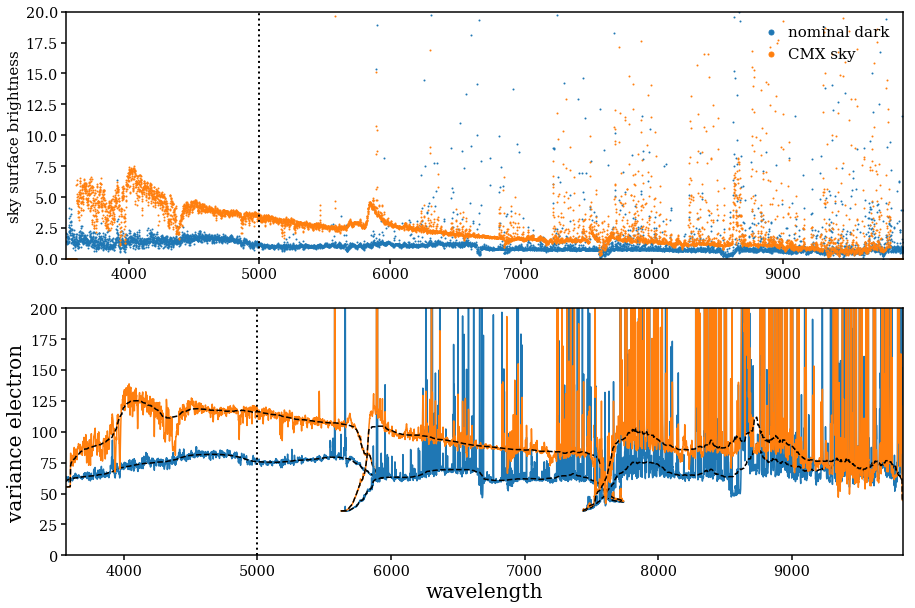

--- 53081 ---


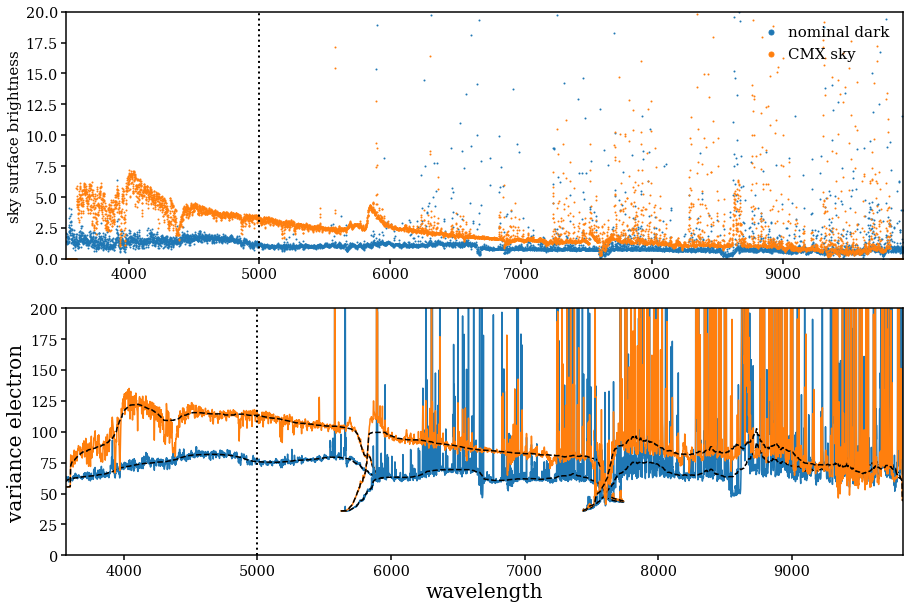

--- 53082 ---


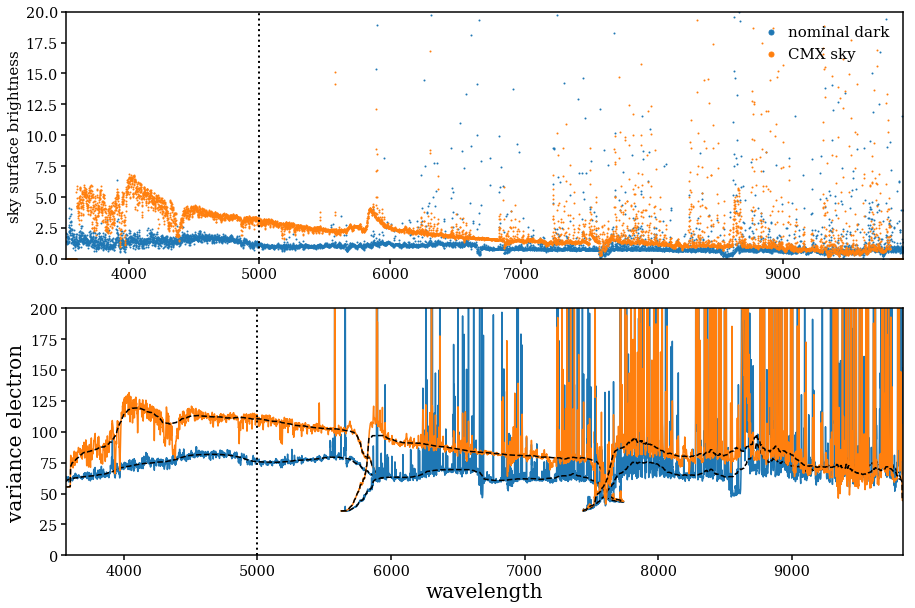

--- 53083 ---


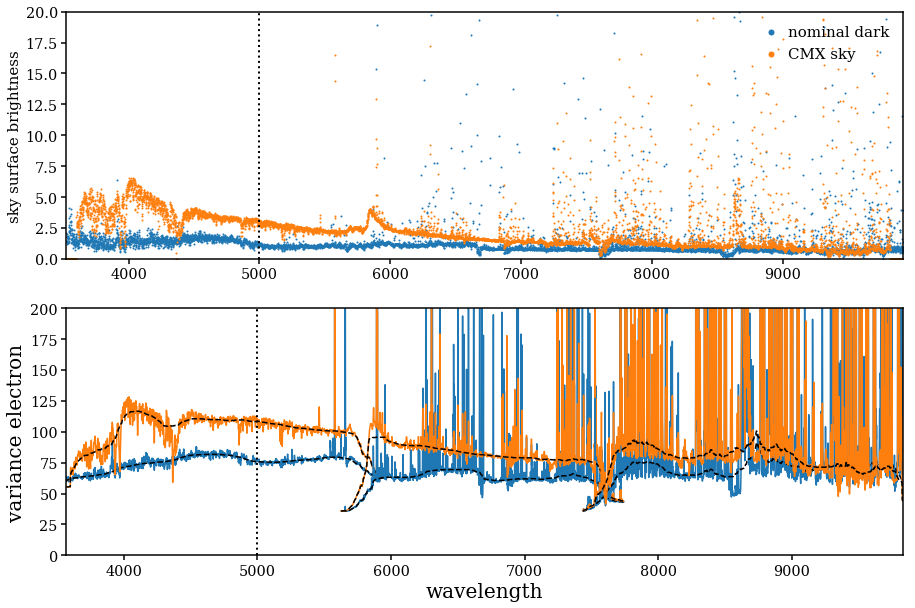

--- 53084 ---


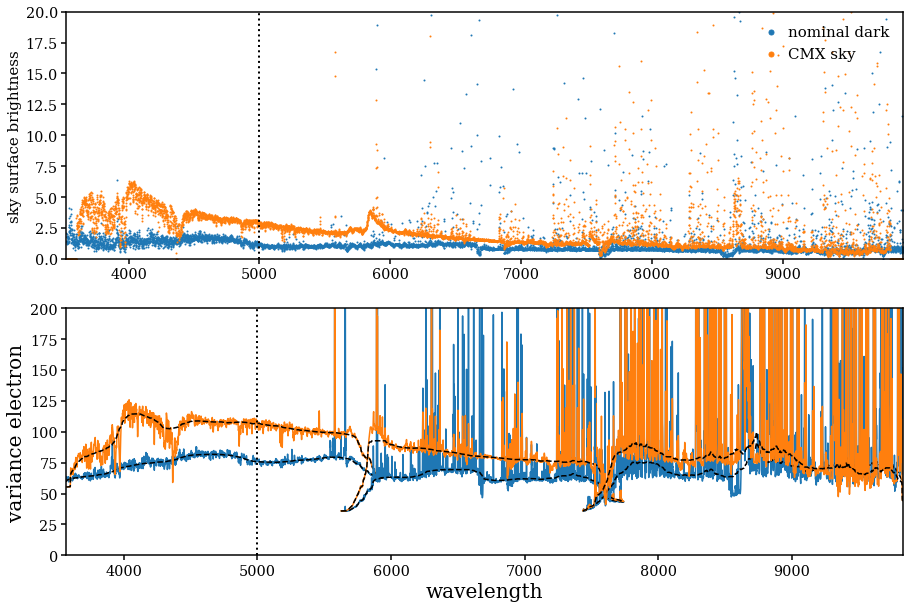

--- 53085 ---


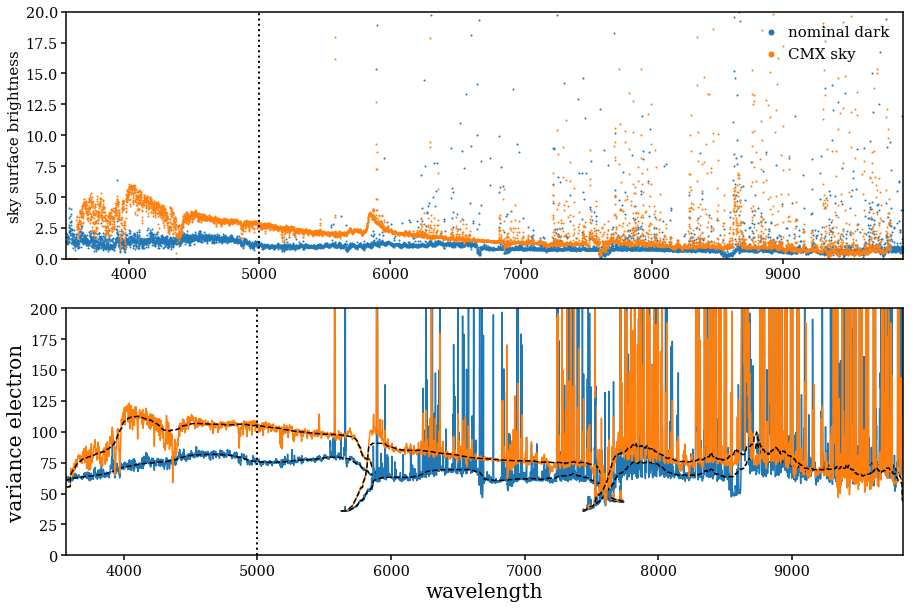

--- 53086 ---


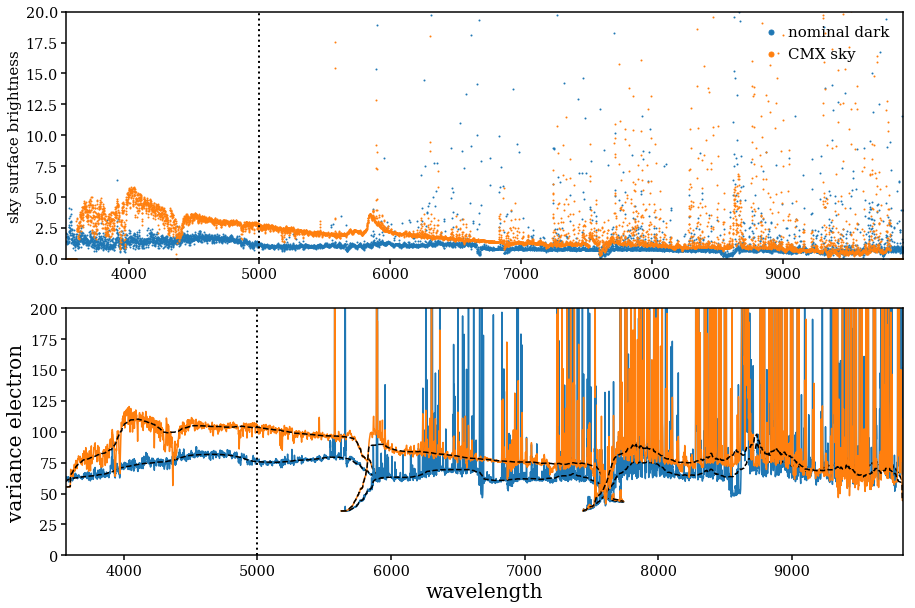

--- 53087 ---


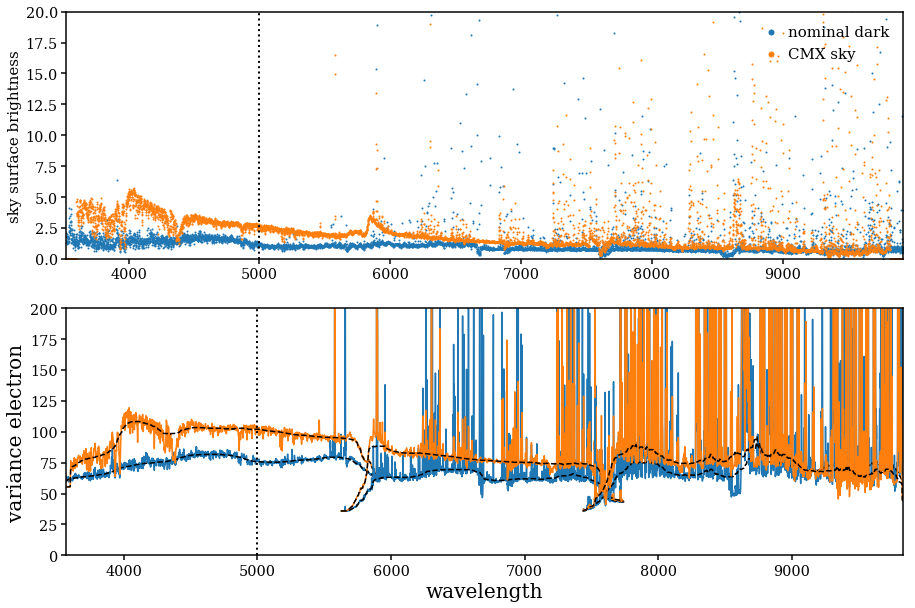

--- 53088 ---


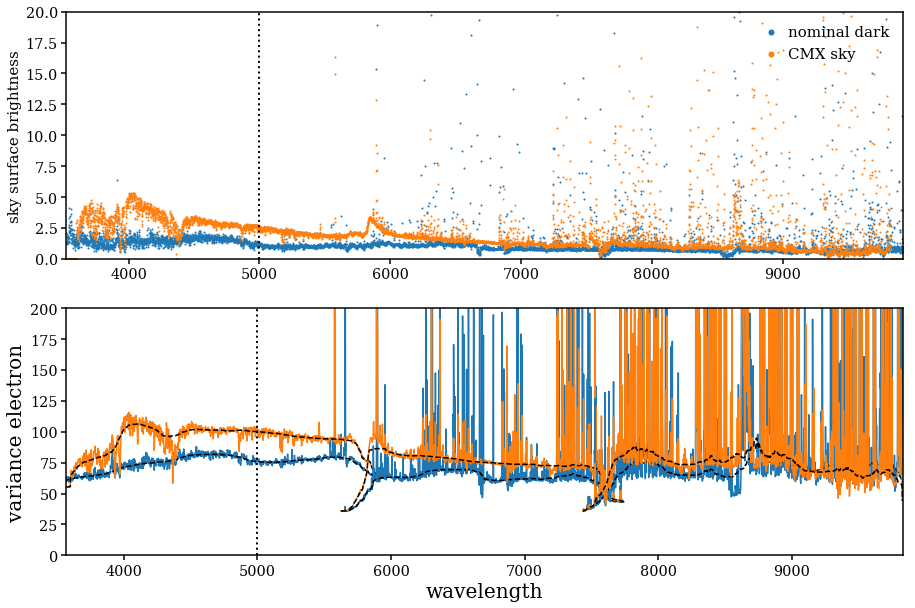

--- 53089 ---


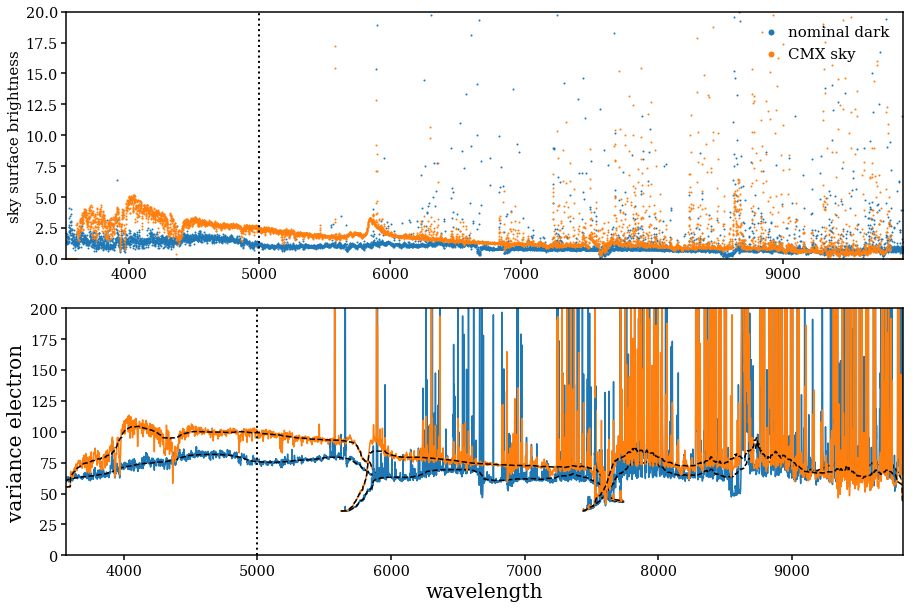

--- 53090 ---


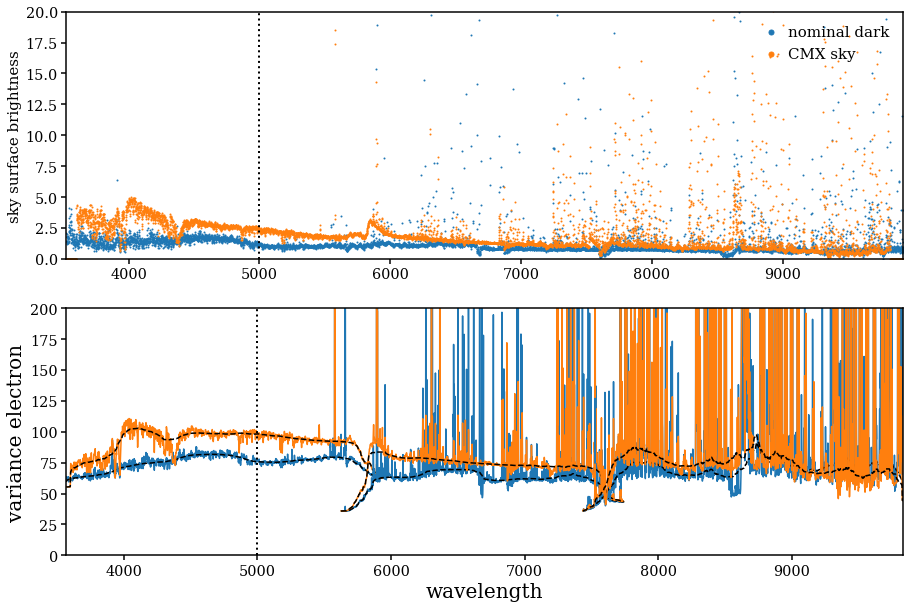

--- 55442 ---


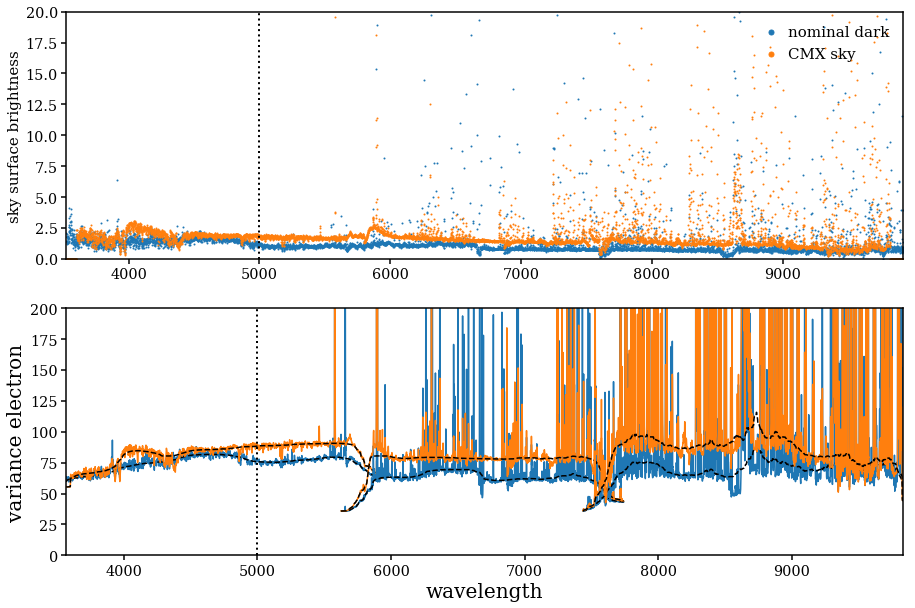

--- 55443 ---


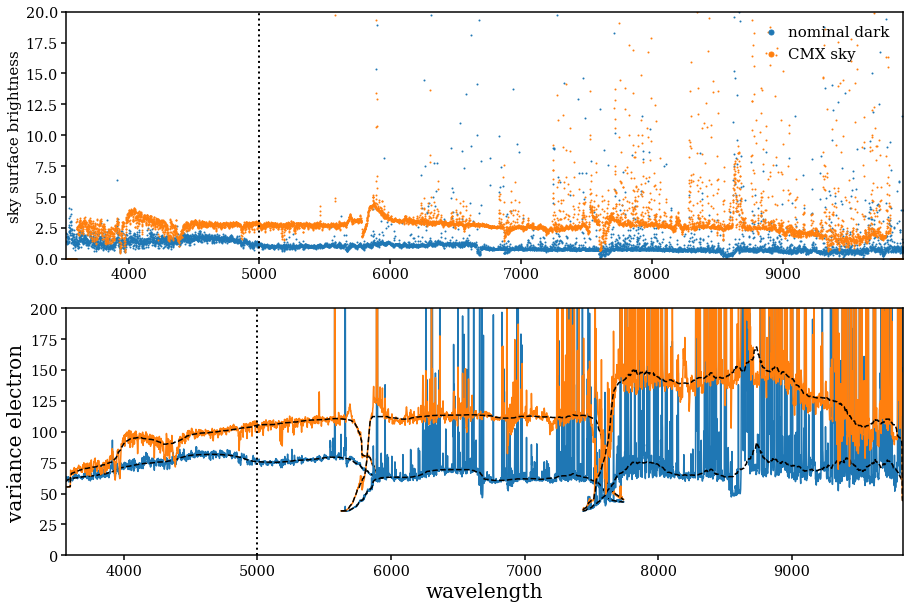

--- 55444 ---


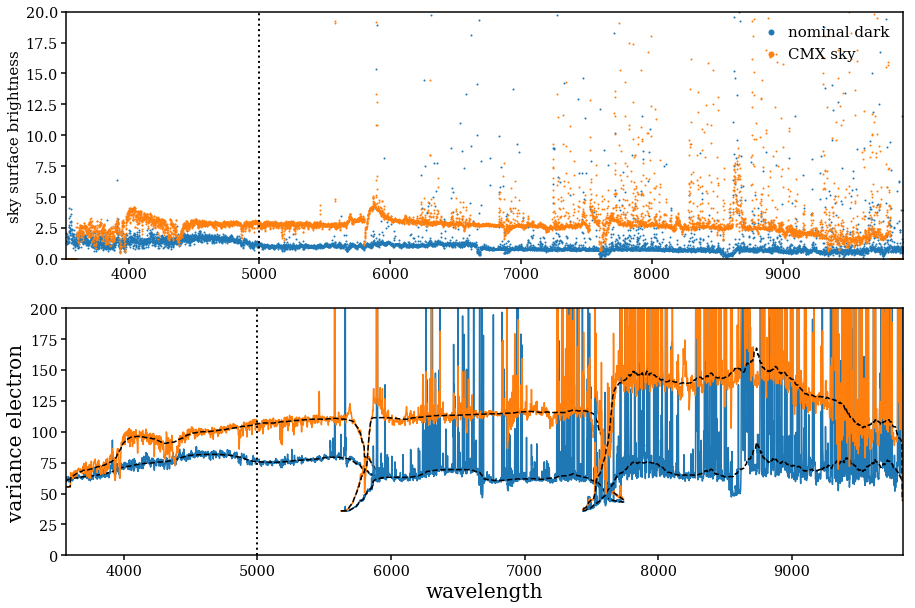

--- 55445 ---


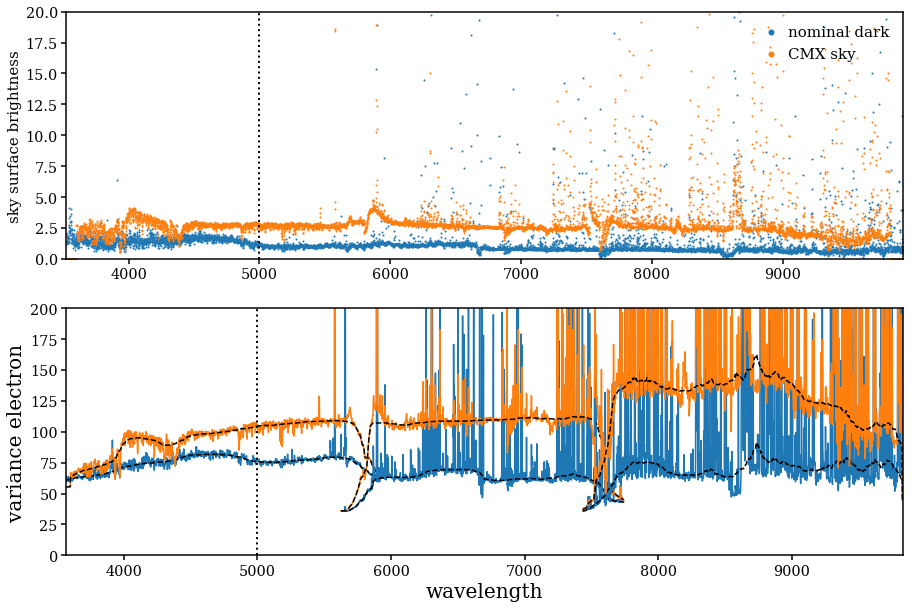

--- 55432 ---


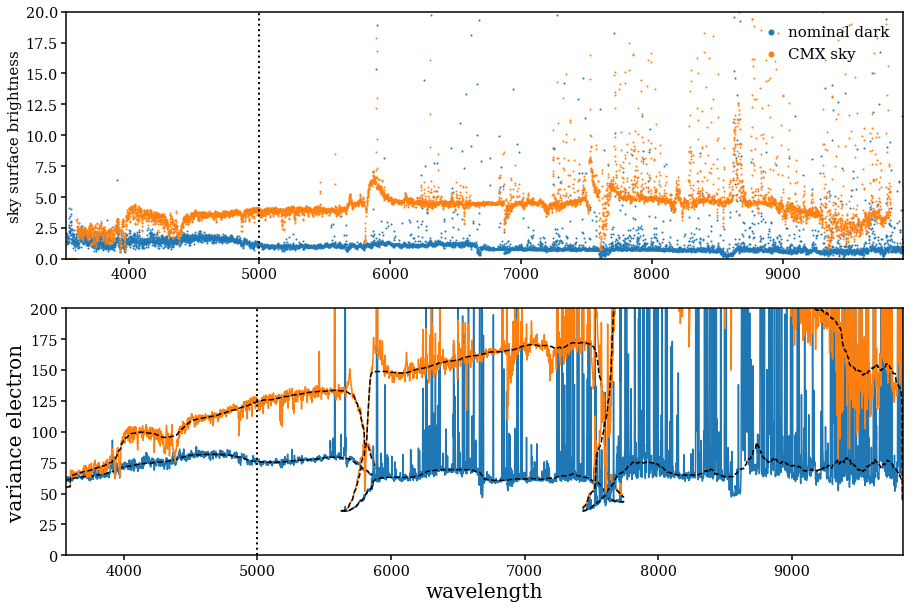

--- 55433 ---


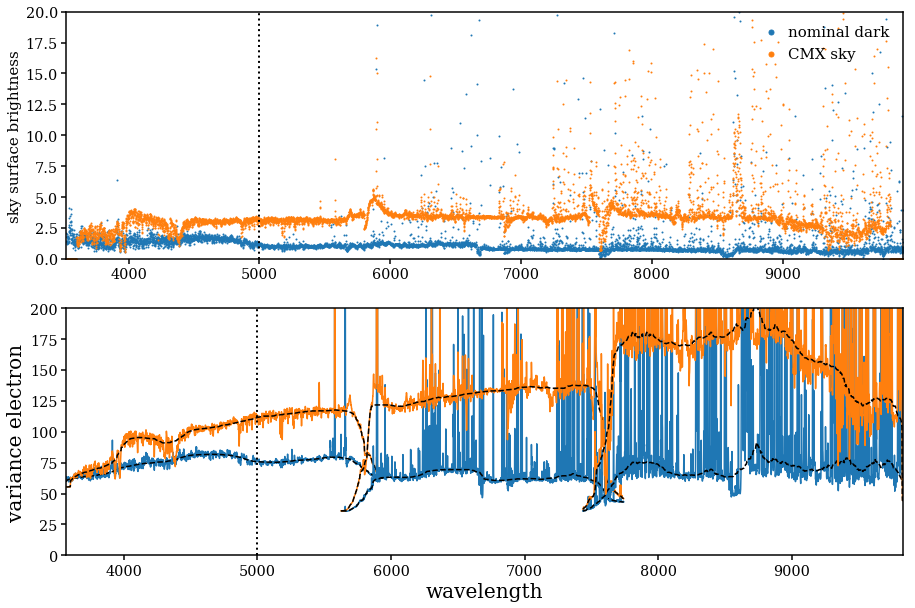

--- 55434 ---


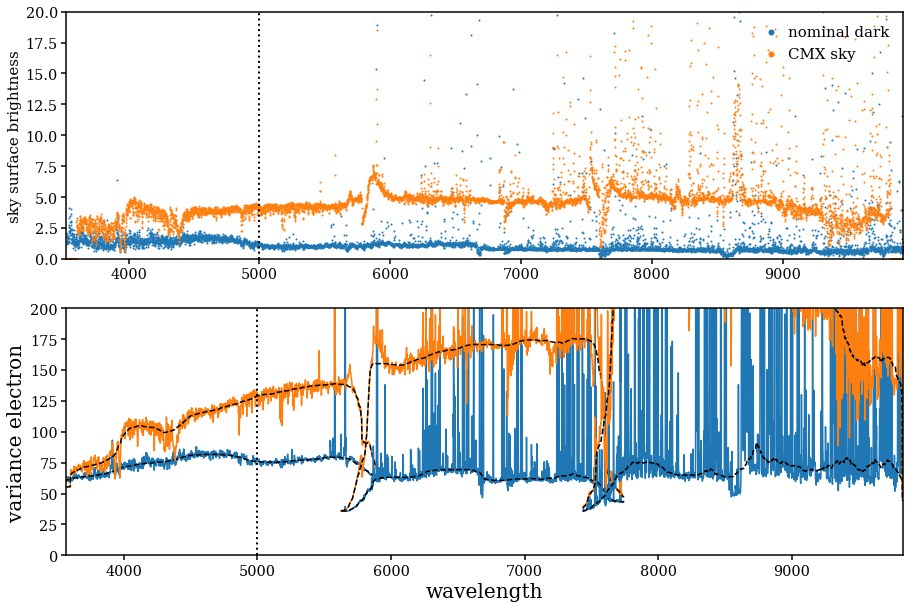

--- 55435 ---


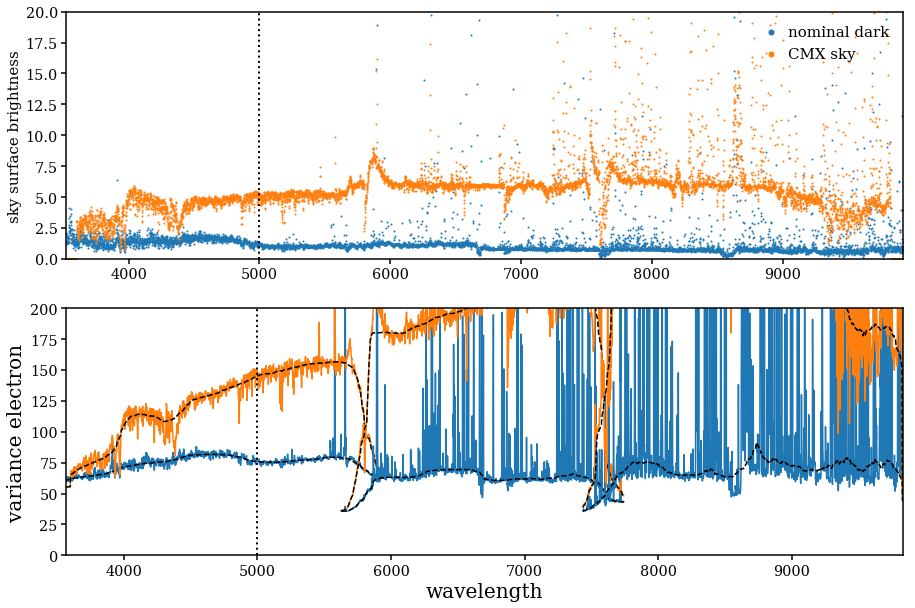

--- 55654 ---


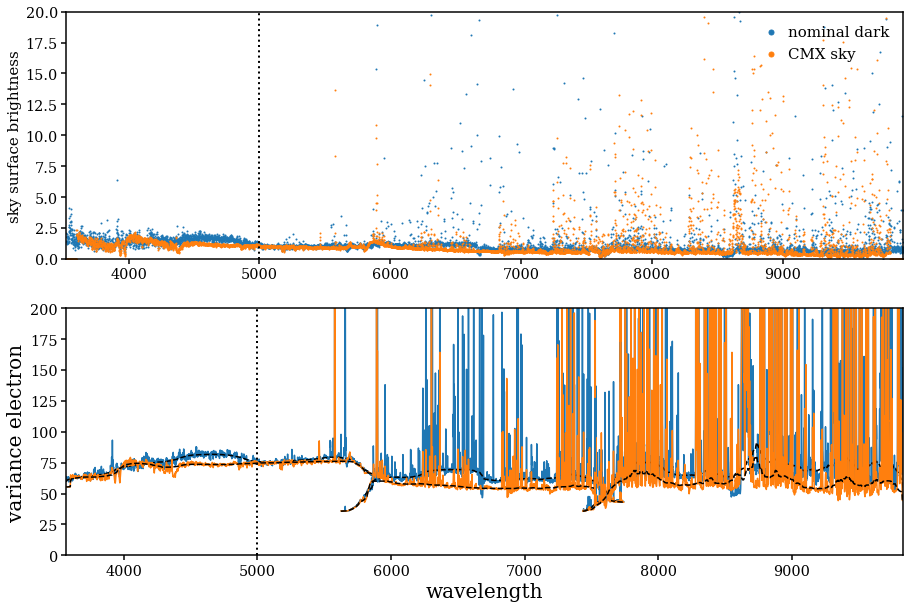

--- 55655 ---


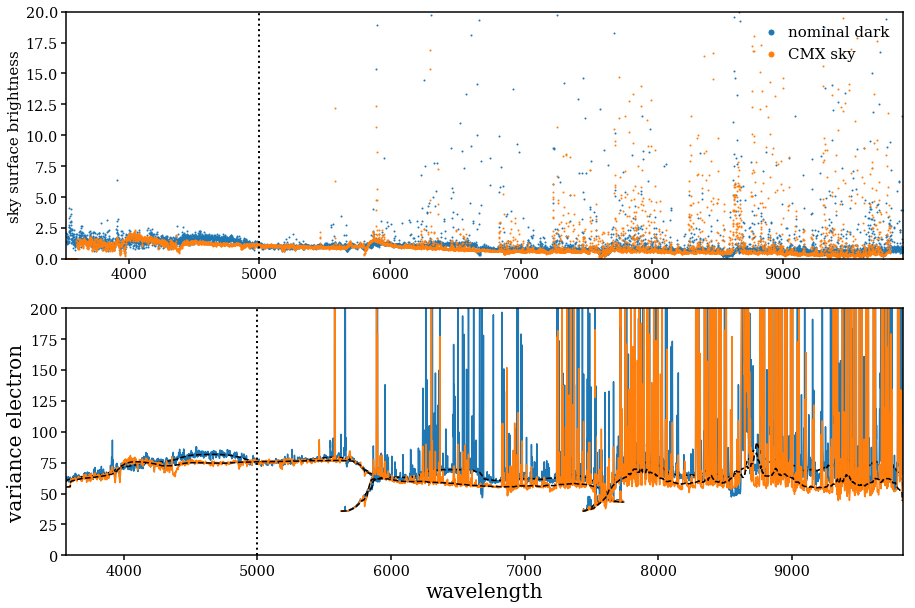

--- 55656 ---


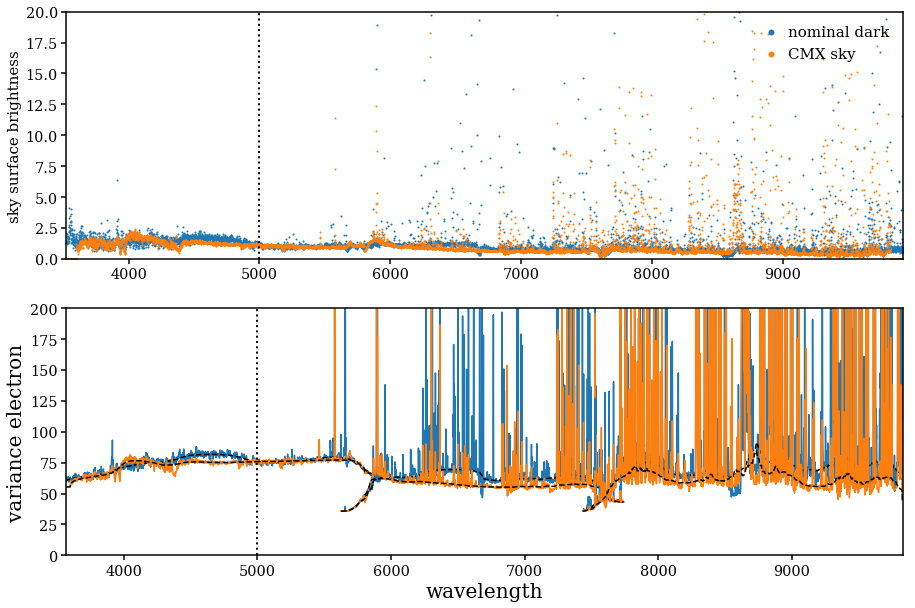

In [13]:
fsky_4000, fsky_5000, fsky_7000 = [], [], []

waves_sky = [skies['wave_b'], skies['wave_r'], skies['wave_z']]

exp0 = 0
for iexp in range(len(skies['expid'])): 
    sky_sbs = [skies['sky_sb_b'][iexp], skies['sky_sb_r'][iexp], skies['sky_sb_z'][iexp]]
    
    plot = False
    if skies['expid'][iexp] != exp0: 
        print('--- %i ---' % skies['expid'][iexp])
        plot = True
        exp0 = skies['expid'][iexp]
    fsky_4000.append(get_fsky(waves_sky, sky_sbs, wavelength=4000))
    fsky_5000.append(get_fsky(waves_sky, sky_sbs, wavelength=5000, plot=plot))
    fsky_7000.append(get_fsky(waves_sky, sky_sbs, wavelength=7000))

In [14]:
piday = (skies['date'] == 20200314)

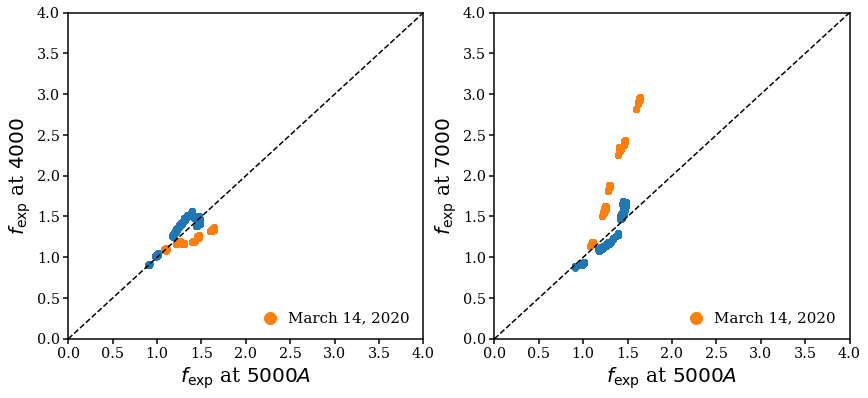

In [22]:
fig = plt.figure(figsize=(14,6))
for i, _fsky, _wave in zip(range(2), [fsky_4000, fsky_7000], [4000, 7000]): 
    sub = fig.add_subplot(1,2,i+1)
    sub.scatter(np.array(fsky_5000), np.array(_fsky))
    sub.scatter(np.array(fsky_5000)[piday], np.array(_fsky)[piday], label='March 14, 2020')
    sub.plot([0., 10.], [0., 10], c='k', ls='--')
    sub.legend(loc='lower right', handletextpad=0.2, markerscale=2, fontsize=15)
    sub.set_xlabel(r'$f_{\rm exp}$ at $5000A$', fontsize=20)
    sub.set_xlim(0., 4.)
    sub.set_ylabel(r'$f_{\rm exp}$ at $%i$' % _wave, fontsize=20)
    sub.set_ylim(0., 4.)

How do these new $f_{\rm sky}$ values correspond with the old sky ratios? 

(0.0, 4.0)

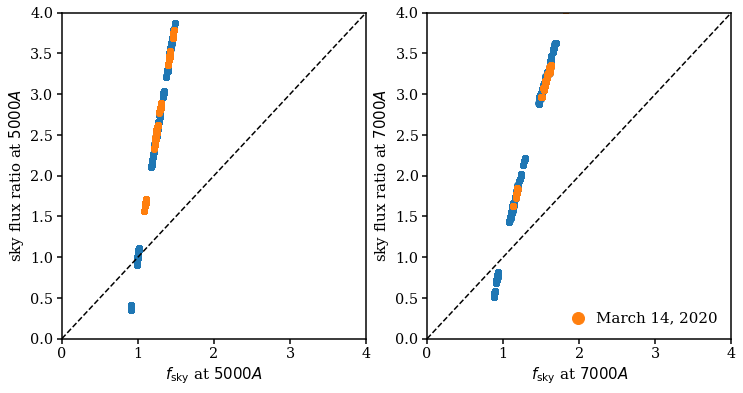

In [16]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(np.array(fsky_5000), skies['sky_ratio_5000'])
sub.scatter(np.array(fsky_5000)[piday], skies['sky_ratio_5000'][piday], label='March 14, 2020')
sub.plot([0., 10.], [0., 10], c='k', ls='--')
sub.set_xlabel(r'$f_{\rm sky}$ at $5000A$', fontsize=15)
sub.set_xlim(0., 4.)
sub.set_ylabel(r'sky flux ratio at $5000A$', fontsize=15)
sub.set_ylim(0., 4.)

sub = fig.add_subplot(122)
sub.scatter(np.array(fsky_7000), skies['sky_ratio_7000'])
sub.scatter(np.array(fsky_7000)[piday], skies['sky_ratio_7000'][piday], label='March 14, 2020')
sub.plot([0., 10.], [0., 10], c='k', ls='--')
sub.legend(loc='lower right', handletextpad=0.2, markerscale=2, fontsize=15)
sub.set_xlabel(r'$f_{\rm sky}$ at $7000A$', fontsize=15)
sub.set_xlim(0., 4.)
sub.set_ylabel(r'sky flux ratio at $7000A$', fontsize=15)
sub.set_ylim(0., 4.)

In [17]:
fskies = h5py.File('/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/sky_fibers.cmx.v1.hdf5', 'a')
fskies.create_dataset('fsky_5000', data=fsky_5000)
fskies.create_dataset('fsky_7000', data=fsky_7000)
fskies.close()